# ML Models for Predicting Number of Hotel Clicks 

Suppose we have a dataset (`hotel_clicks.csv`) which only records the daily number of hotel clicks from Janurary to August in 2020. Here we want to empoy machine learning models to predict this number across September 2020. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

**STEP 1: Load and Inspect Data**

In [6]:
df = pd.read_csv("hotel_clicks.csv")
df.head()

,Unnamed: 0,date,clicks
0,0,20200101,19800
1,1,20200102,22659
2,2,20200103,22606
3,3,20200104,20735
4,4,20200105,21988


In [7]:
print("Checking the shape of the data...")
print(df.shape)
print("Checking if there are any nulls...")
print(df.isnull().sum())
print("Checking if there are any duplicates...")
print(len(df) != len(df.drop_duplicates()))

Checking the shape of the data...
(242, 3)
Checking if there are any nulls...
Unnamed: 0    0
date          0
clicks        0
dtype: int64
Checking if there are any duplicates...
False


In [8]:
df.describe()

,Unnamed: 0,date,clicks
count,242.000000,2.420000e+02,242.000000
mean,120.500000,2.020047e+07,19775.735537
std,70.003571,2.296569e+02,5858.323459
min,0.000000,2.020010e+07,7902.000000
25%,60.250000,2.020030e+07,15589.250000
50%,120.500000,2.020050e+07,18531.000000
75%,180.750000,2.020068e+07,22577.500000
max,241.000000,2.020083e+07,39602.000000


As seen in the above, there are only two columns `date` and `clicks` and data quality is pretty good (no nulls, duplicates, and anomalies). 

**STEP 2: Clean and Prepare Data**

The purpose of data clean is to deal with nulls, duplicates and anomalies if there are. Since our data quality is already fine, we do not need to clean our data.

Now we come to prepare the data for training. For this we convert the `date` column into six columns named `year`, `month`, `date`, `week`,  `dayofweek`, and `dayofyear`.

In [11]:
data = df.copy()
data["date"] = data["date"].apply(lambda x: pd.to_datetime(str(x), format="%Y%m%d", errors="ignore"))
date = data["date"]
clicks = data["clicks"]

data = pd.DataFrame({"year": date.dt.year,
                     "month": date.dt.month,
                     "date": date.dt.day,
                     "week": date.dt.week,
                     "dayofweek": date.dt.dayofweek,
                     "dayofyear": date.dt.dayofyear,
                     "clicks": clicks})
data.head()

,year,month,date,week,dayofweek,dayofyear,clicks
0,2020,1,1,1,2,1,19800
1,2020,1,2,1,3,2,22659
2,2020,1,3,1,4,3,22606
3,2020,1,4,1,5,4,20735
4,2020,1,5,1,6,5,21988


Now we get ready to extract input features (`X`) and target output (`Y`) for training. Because the `clicks` column will be used as target output (`Y`) and the `year` column has a constant value of 2020 (no variance), we can simply exclude the `year` and `clicks` columns when extracting input features (`X`). 

In [12]:
# Prepare X/Y
Y = data["clicks"].values
exclude = ["year", "clicks"]
X = data.drop(exclude, axis=1)

**STEP 3: Build/Train/Evaluate Models**

With `X` and `Y` prepared, we can now build, train, and evaluate a regression model using `sklearn`. For comparative purposes, we will implement four different regression models, i.e., `Linear Regression`, `Logistic Regression`, `Decision Tree Regressor`, and `Random Forest Regressor`. We will split our data into training and testing sets and evaluate/compare their accuracy scores.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=1)

models = []
models.append(("LinearRegression", LinearRegression()))
models.append(("LogisticRegression", LogisticRegression()))
models.append(("DecisionTreeRegressor", DecisionTreeRegressor()))
models.append(("RandomForestRegressor", RandomForestRegressor(random_state=1)))

for name, model in models:
    print("----------------------------------")
    model.fit(X_Train, Y_Train)
    print(f"Evaluate {name} Model")
    R2 = model.score(X_Test, Y_Test).round(decimals=3)
    RMSE = np.sqrt(mean_squared_error(y_true=Y_Test, y_pred=model.predict(X_Test))).round(decimals=3)
    print(f"R2 Score = {R2}")
    print(f"RMSE Score = {RMSE}")

----------------------------------
Evaluate LinearRegression Model
R2 Score = 0.184
RMSE Score = 5555.951
----------------------------------
Evaluate LogisticRegression Model
R2 Score = 0.0
RMSE Score = 5984.655
----------------------------------
Evaluate DecisionTreeRegressor Model
R2 Score = 0.727
RMSE Score = 3214.471
----------------------------------
Evaluate RandomForestRegressor Model
R2 Score = 0.853
RMSE Score = 2357.53


As seen from the R2 and RMSE scores, the `RandomForestRegressor` model gives the best prediction accuracy. Note that for all the models we did not tune any hyper parameters.

### STEP 4: Cross-Validate Models

To really make sure that our models were not over fitted, we need to check their cross-validation scores. Here we just take the `RandomForestRegressor` model for this checking.

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

name = "RandomForestRegressor"
model = RandomForestRegressor(random_state=1)

print("Cross-Validation Results...")

# Use 10-fold cross validation (90% training, 10% test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=cross_validation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
r2_scores = cross_val_score(model, X, Y, scoring="r2", cv=cross_validation, n_jobs=1)

mean_r2_score = np.mean(np.abs(r2_scores))
mean_rmse_score = np.mean(np.abs(rmse_scores))

print("------------------------")
print(f"Evaluate {name} Model")
print(f"Mean R2 Score = {mean_r2_score}")
print(f"Mean RMSE Score = {mean_rmse_score}")

Cross-Validation Results...
------------------------
Evaluate RandomForestRegressor Model
Mean R2 Score = 0.8177662666224347
Mean RMSE Score = 2231.42612270567


From the cross-validation results, we find out that the model was a little over-fitted (but still good). 

**STEP 5: Tune Hyper-Parameters**

Now let's play around with tuning some model parameters to further improve the model accuracy. 

In [15]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 200, 300, 400, 500] # number of random trees
max_depth = [2, 4, 6, 8, 10] # number of depth for which tree grows
parameters = {"n_estimators": n_estimators, "max_depth": max_depth}

name = "RandomForestRegressor"
model = RandomForestRegressor(random_state=1)

gscv = GridSearchCV(model, parameters, scoring="neg_mean_squared_error")
gscv.fit(X_Train, Y_Train)

best = gscv.best_estimator_

best.fit(X_Train, Y_Train)
print(f"Evaluate Best {name} Model")
R2 = best.score(X_Test, Y_Test).round(decimals=3)
RMSE = np.sqrt(mean_squared_error(y_true=Y_Test, y_pred=best.predict(X_Test))).round(decimals=3)
print(f"R2 Score = {R2}")
print(f"RMSE Score = {RMSE}")

Evaluate Best RandomForestRegressor Model
R2 Score = 0.849
RMSE Score = 2391.521


So the model accuracy does improve by tuning the hyper parameters. In the following, we will use the improved model to predict the daily number of clicks in September 2020. 

**STEP 6: Save (and Load) Models**

As seen from the above, it often involves quite a few steps (e.g. from data cleaning/preprocessing to model training/evaluating) to obtain an accurate model, which means it would take a lot of time for a very complex model. In order not to repeat this heavy work, we need to save our models such that we can just load them for reuse in the future.

In [18]:
import joblib
joblib.dump(best, f"{name}")

['RandomForestRegressor']

**STEP 7: Predict/Visualize Data**

Now we use our saved models without and with improvement to predict the daily number of clicks in September 2020. 

We first create a new dataset with only one column named `date`, which writes all the dates from 01-09-2020 to 30-09-2020.

In [19]:
# Create a new dataframe
sep = ["202009%02d" % day for day in range(1, 31)]
df2 = pd.DataFrame({"date": sep})

Next we convert the `date_ymd` column into six columns named `year`, `month`, `date`, `week`,  `dayofweek`, and `dayofyear`.

In [20]:
data2 = df2.copy()
data2["date"] = data2["date"].apply(lambda x: pd.to_datetime(str(x), format="%Y%m%d", errors="ignore"))
date = data2["date"]
data2 = pd.DataFrame({"year": date.dt.year,
                      "month": date.dt.month,
                      "date": date.dt.day,
                      "week": date.dt.week,
                      "dayofweek": date.dt.dayofweek,
                      "dayofyear": date.dt.dayofyear})

Now let's predict and visualize the daily number of clicks in September 2020.

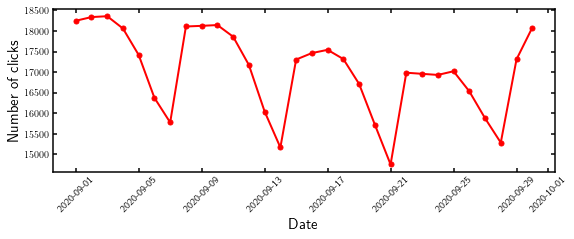

In [21]:
# Load the model
model = joblib.load(f"{name}")

X_Sep = data2.drop("year", axis=1)
Y_Sep_Predict = model.predict(X_Sep).round(decimals=0).astype(int)

df2["clicks"] = Y_Sep_Predict
p = df2.copy()
p["date"] = p["date"].apply(lambda x: pd.to_datetime(str(x), format="%Y%m%d"))

plt.figure(figsize=(9, 3))
x = p["date"].values
y = p["clicks"].values
plt.plot(x, y, "ro-", lw=2, ms=5)
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Number of clicks", fontsize=15)
plt.show()

Finally let's merge the two datasets `df1` and `df2` together and plot both the actual and predicted daily numbers of clicks from 2019-01-01 to 2019-09-30.

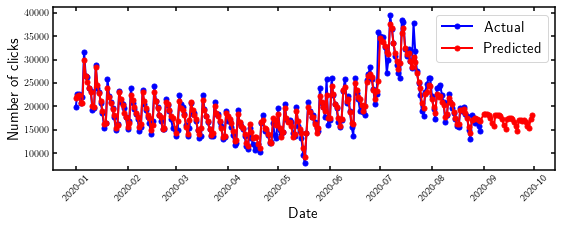

In [23]:
X_All = np.concatenate([X, X_Sep])
Y_All_Predict = model.predict(X_All).round(decimals=0).astype(int)

df_all = df.append(df2, sort=False)
p = df_all.copy()
pp = p.apply(pd.to_numeric) 
p["date"] = p["date"].apply(lambda x: pd.to_datetime(str(x), format="%Y%m%d"))
X1 = p["date"][pp["date"]<=20200831].values
X2 = p["date"].values

plt.figure(figsize=(9, 3))
plt.plot(X1, Y, "bo-", lw=2, ms=5, label="Actual")
plt.plot(X2, Y_All_Predict, "ro-", lw=2, ms=5, label="Predicted")
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Number of clicks", fontsize=15)
plt.legend(fontsize=15)
plt.show()

As seen from the prediction, there is a good agreement between the acutal and predicted values for the daily number of clicks between 2020.01 and 2020.08. Meanwhile, the daily number of clicks in 2020.09 is reduced a lot when compared to that between 2020.07 and 2020.08.